# Bone Mineral Density Prediction

## Data Dictionary
This dataset was downloaded from Kaggle
https://www.kaggle.com/datasets/amarsharma768/bmd-data

| Column | Description |
|---|---|
| id |  id of individual |
| Age | Age of individual |
| Sex | Gender of individual |
| fracture | Fracture status of individual |
| weight_kg | Weight in kg of individual |
| height_cm |  Height in cm of individual |
| medication |  Medication individual is on |
| bmd  | Bone Mineral Density of individual |





## 1. Import Libraries and load Data

**What we do here:**
- Import essential libraries.
- Load `bmd.csv` .
- Show the first few rows to confirm the schema.

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler , LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report ,roc_curve

RANDOM_STATE= 42

In [21]:
csv_path="../Data/raw/bmd.csv"

data=pd.read_csv(csv_path)
print("\nFirst 5 Rows of the dataset:")
data.head()



First 5 Rows of the dataset:


,id,age,sex,fracture,weight_kg,height_cm,medication,waiting_time,bmd
0,469,57.052768,F,no fracture,64.0,155.5,Anticonvulsant,18,0.8793
1,8724,75.741225,F,no fracture,78.0,162.0,No medication,56,0.7946
2,6736,70.778900,M,no fracture,73.0,170.5,No medication,10,0.9067
3,24180,78.247175,F,no fracture,60.0,148.0,No medication,14,0.7112
4,17072,54.191877,M,no fracture,55.0,161.0,No medication,20,0.7909


## 2. Understanding and exploring Data

**what we do here:**
- Inspect data types, missing values
- Get statistics


In [32]:
print("\nStatistical Summary:")
print(data.describe())
print("Non-numerical count")
print(data['fracture'].value_counts())
print(data['medication'].value_counts())
print(data["sex"].value_counts())



Statistical Summary:
                 id         age   weight_kg   height_cm  waiting_time  \
count    169.000000  169.000000  169.000000  169.000000    169.000000   
mean    9102.556213   63.631531   64.665680  160.254438     19.739645   
std     8744.623598   12.356936   11.537171    7.928272     15.800570   
min       35.000000   35.814058   36.000000  142.000000      5.000000   
25%     2018.000000   54.424211   56.000000  154.000000      9.000000   
50%     6702.000000   63.487837   64.500000  160.500000     14.000000   
75%    17100.000000   72.080558   73.000000  166.000000     24.000000   
max    24208.000000   88.753795   96.000000  177.000000     96.000000   

              bmd  
count  169.000000  
mean     0.783104  
std      0.166529  
min      0.407600  
25%      0.670800  
50%      0.786100  
75%      0.888800  
max      1.362400  
Non-numerical count
fracture
no fracture    119
fracture        50
Name: count, dtype: int64
medication
No medication      136
Glucocorticoi

In [33]:
print("\nData Types and Missing Values:")
data.isnull().sum()


Data Types and Missing Values:


id              0
age             0
sex             0
fracture        0
weight_kg       0
height_cm       0
medication      0
waiting_time    0
bmd             0
dtype: int64

## 3. Data Handling

**what we do here:**
- Drop irrelevant columns e.g. waiting_time

In [22]:
data.drop(columns=["waiting_time"], inplace=True)
print(data.columns)

Index(['id', 'age', 'sex', 'fracture', 'weight_kg', 'height_cm', 'medication',
       'bmd'],
      dtype='object')


## 4. Checking for imbalance ##
**what we do here** 
- counting variables in the column
- handling the imbalancy using simple duplication 

C:\Users\Pavilion\AppData\Local\Temp\ipykernel_14160\3100918795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


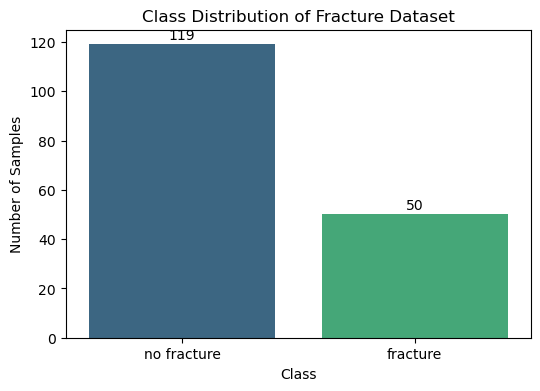

In [23]:
class_counts = data['fracture'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Annotate bars with counts
for i, count in enumerate(class_counts.values):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.title("Class Distribution of Fracture Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [24]:
from imblearn.over_sampling import RandomOverSampler

X = data.drop(columns=['fracture'])
y = data['fracture']

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

print(y_res.value_counts())

fracture
no fracture    119
fracture       119
Name: count, dtype: int64


## 5. Outlier Detection and Handling

**what we do here:**
- Visualize the dataset to see the outliers
- Use IQR to handle outliers

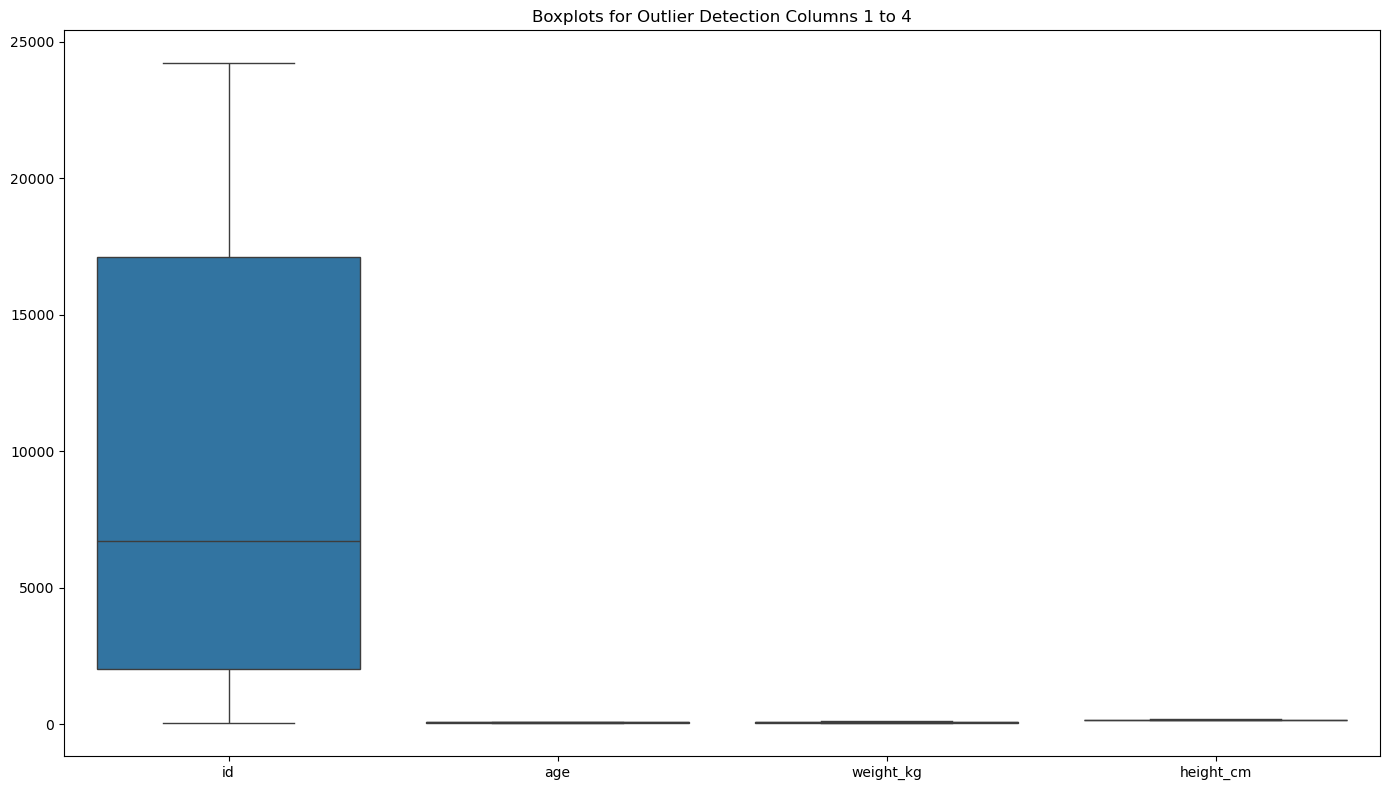

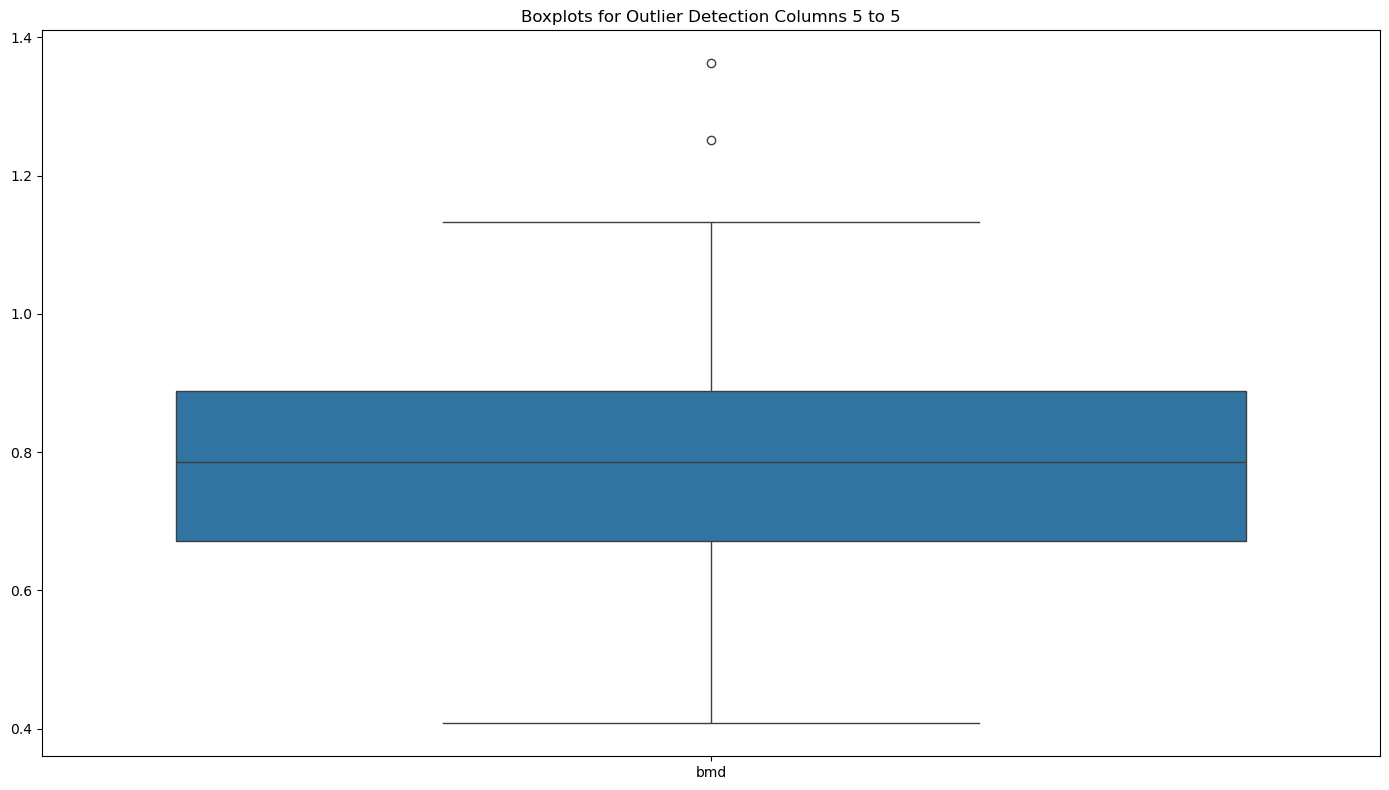

In [13]:
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
n_columns = len(numeric_cols)

group_size = 4
n_plots = (n_columns + group_size - 1) // group_size

for i in range(n_plots):
    start_col = i * group_size
    end_col = min((i + 1) * group_size, n_columns)
    cols_to_plot = numeric_cols[start_col:end_col]

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=data[cols_to_plot])
    plt.title(f'Boxplots for Outlier Detection Columns {start_col + 1} to {end_col}')
    plt.tight_layout()
    plt.show()


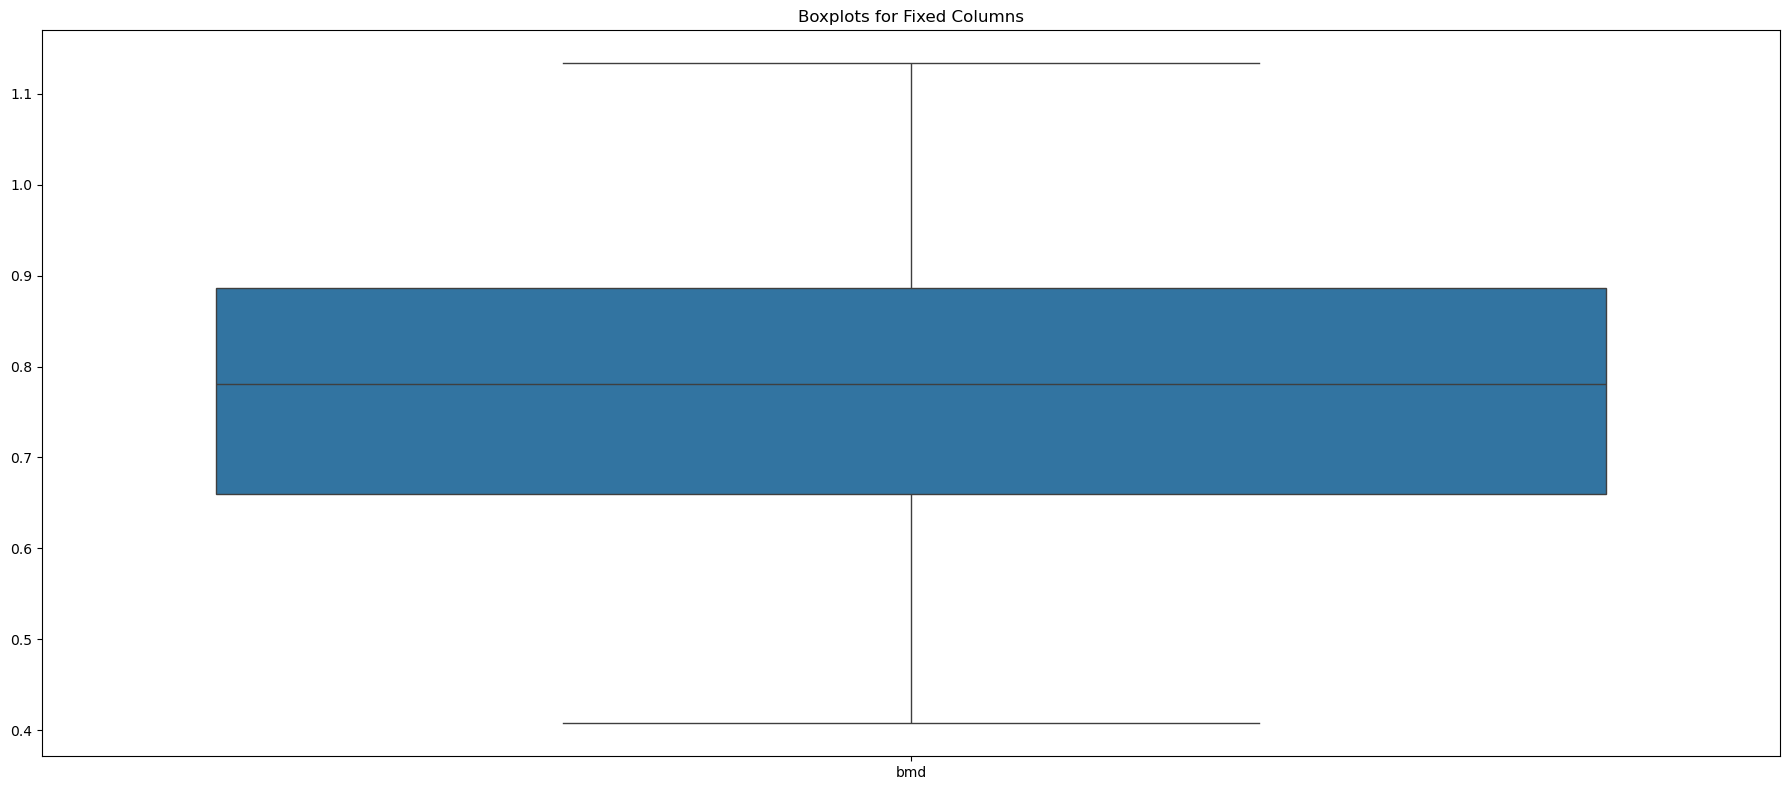

In [17]:
# handling outliers using IQR for column:"bmd"

columns_to_plot = ["bmd"]

for col in columns_to_plot:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

plt.figure(figsize=(18, 8))
sns.boxplot(data=data[columns_to_plot])
plt.title("Boxplots for Fixed Columns")
plt.tight_layout()
plt.show()


## 6. Encodoing data ##
**what we do here**
- use label encoding
- use one hot encoding
- compare to know which one is better in our case

**6.1. Label Encoding**
**what we do here:**
- Encode numeric values for categorical columns (fracture, medication and sex)
- Ensure their count matches when the columns were non-numerical

In [18]:
# Label Encoding for categorical columns
encoder = LabelEncoder()
data['fracture'] = encoder.fit_transform(data['fracture'])
data['medication'] = encoder.fit_transform(data['medication'])
data["sex"] = encoder.fit_transform(data["sex"])
data.head()

,id,age,sex,fracture,weight_kg,height_cm,medication,bmd
0,469,57.052768,0,1,64.0,155.5,0,0.8793
1,8724,75.741225,0,1,78.0,162.0,2,0.7946
2,6736,70.778900,1,1,73.0,170.5,2,0.9067
3,24180,78.247175,0,1,60.0,148.0,2,0.7112
4,17072,54.191877,1,1,55.0,161.0,2,0.7909


Label Encoding Results:
Test Mean Squared Error: 0.0104
Test R^2 Score: 0.4869


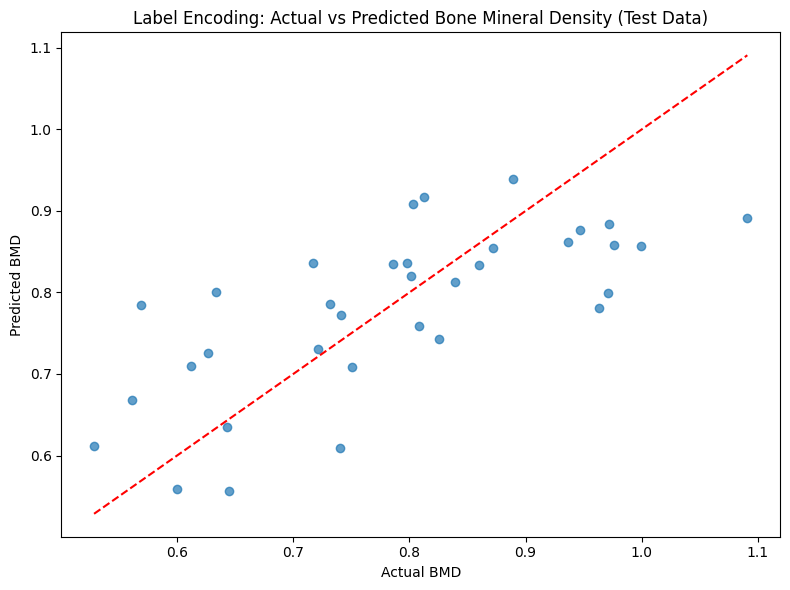

In [ ]:
# Split features and target for Label Encoding
x = data.drop("bmd", axis=1)
y = data["bmd"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate Label Encoding model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Calculate metrics for Label Encoding
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Label Encoding Results:")
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Test R^2 Score: {r2_test:.4f}")

# Plot actual vs predicted for Label Encoding
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual BMD")
plt.ylabel("Predicted BMD")
plt.title("Label Encoding: Actual vs Predicted Bone Mineral Density (Test Data)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

**6.2 One hot enconding**

One-Hot Encoding Results:
Test Mean Squared Error: 0.0102
Test R^2 Score: 0.4952


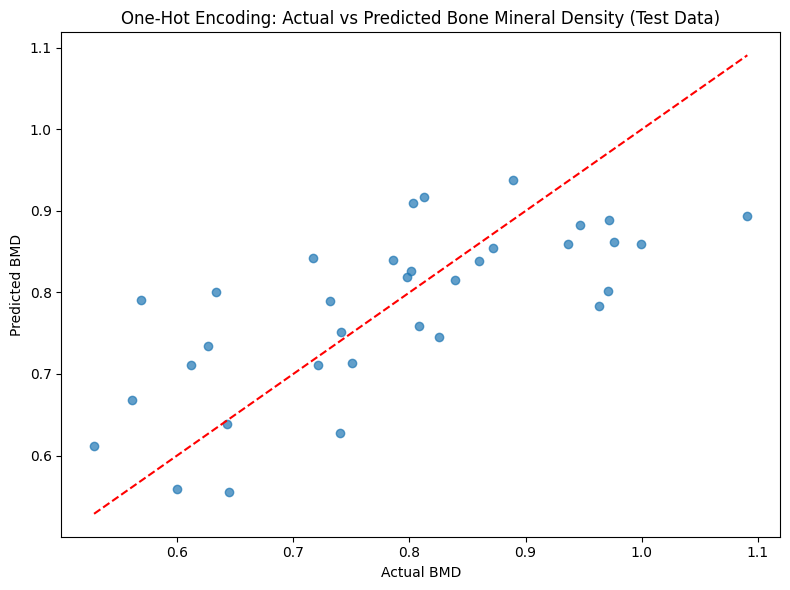

In [39]:
# One-Hot Encoding for categorical columns
data_ohe = pd.get_dummies(data, columns=['fracture', 'medication', 'sex'])

# Split features and target
x_ohe = data_ohe.drop("bmd", axis=1)
y_ohe = data_ohe["bmd"]
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(x_ohe, y_ohe, test_size=0.2, random_state=RANDOM_STATE)

# Scale Data 
scaler = StandardScaler()
X_train_ohe_scaled = scaler.fit_transform(X_train_ohe)
X_test_ohe_scaled = scaler.transform(X_test_ohe)

# Train and evaluate model
lr_ohe = LinearRegression()
lr_ohe.fit(X_train_ohe_scaled, y_train_ohe)
y_pred_ohe = lr_ohe.predict(X_test_ohe_scaled)

# Calculate metrics for One-Hot Encoding
mse_test_ohe = mean_squared_error(y_test_ohe, y_pred_ohe)
r2_test_ohe = r2_score(y_test_ohe, y_pred_ohe)

# Print One-Hot Encoding Results
print("One-Hot Encoding Results:")
print(f"Test Mean Squared Error: {mse_test_ohe:.4f}")
print(f"Test R^2 Score: {r2_test_ohe:.4f}")

# Plot actual vs predicted for One-Hot Encoding
plt.figure(figsize=(8,6))
plt.scatter(y_test_ohe, y_pred_ohe, alpha=0.7)
plt.xlabel("Actual BMD")
plt.ylabel("Predicted BMD")
plt.title("One-Hot Encoding: Actual vs Predicted Bone Mineral Density (Test Data)")
plt.plot([y_test_ohe.min(), y_test_ohe.max()], [y_test_ohe.min(), y_test_ohe.max()], 'r--')
plt.tight_layout()
plt.show()

**6.3 Model Performance Comparison**
**what we do here**
- Comparing Label Encoding vs One-Hot Encoding based on:
- Mean Squared Error (MSE) - Lower is better
- R² Score - Higher is better (closer to 1)

In [40]:
#comparison of both encoding methods
print("=== Performance Comparison ===")
print("\nLabel Encoding:")
print(f"MSE: {mse_test:.4f}")
print(f"R²:  {r2_test:.4f}")

print("\nOne-Hot Encoding:")
print(f"MSE: {mse_test_ohe:.4f}")
print(f"R²:  {r2_test_ohe:.4f}")

# Determine which method is better
print("\n=== Conclusion ===")
if mse_test_ohe < mse_test:
    print("One-Hot Encoding performed better")
elif mse_test_ohe > mse_test:
    print("Label Encoding performed better")
else:
    print("Both methods performed similarly")

=== Performance Comparison ===

Label Encoding:
MSE: 0.0104
R²:  0.4869

One-Hot Encoding:
MSE: 0.0102
R²:  0.4952

=== Conclusion ===
One-Hot Encoding performed better


## 7. Linear regression vs polynomial from previous assignment ##

Linear regression on it's own

Train Mean Squared Error: 0.0099
Train R^2 Score: 0.6141
Test Mean Squared Error: 0.0102
Test R^2 Score: 0.4952


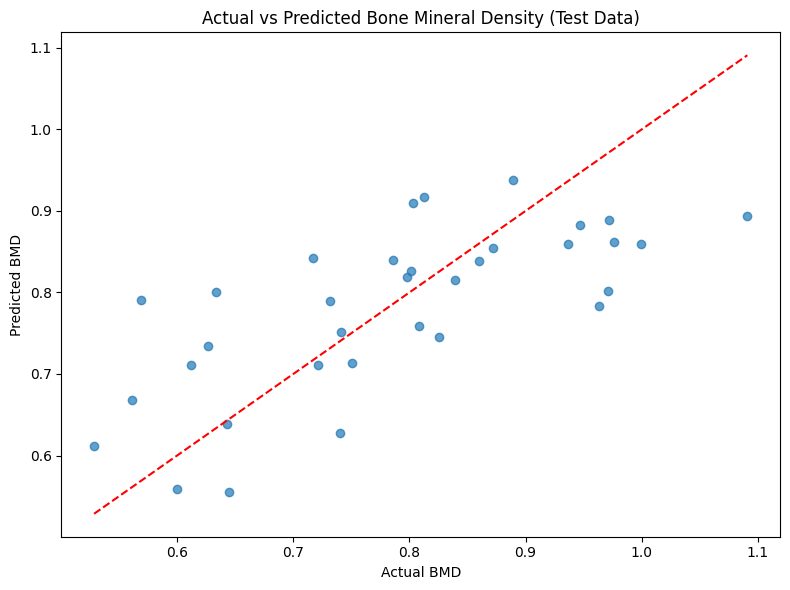

Model is likely underfitting (low R^2 on test set)


In [41]:
# 7. Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score 

# Initialize and train the model 
lr = LinearRegression()
lr.fit(X_train_ohe_scaled, y_train_ohe) 

# Predict on train and test data
y_train_pred = lr.predict(X_train_ohe_scaled)
y_pred = lr.predict(X_test_ohe_scaled) 

# Evaluate the model
mse_train = mean_squared_error(y_train_ohe, y_train_pred)
r2_train = r2_score(y_train_ohe, y_train_pred)
print(f"Train Mean Squared Error: {mse_train:.4f}") 
print(f"Train R^2 Score: {r2_train:.4f}") 
mse_test = mean_squared_error(y_test_ohe, y_pred)
r2_test = r2_score(y_test_ohe, y_pred) 
print(f"Test Mean Squared Error: {mse_test:.4f}") 
print(f"Test R^2 Score: {r2_test:.4f}") 

#Plot actual vs predicted (test only)
plt.figure(figsize=(8,6))
plt.scatter(y_test_ohe, y_pred, alpha=0.7)
plt.xlabel("Actual BMD")
plt.ylabel("Predicted BMD")
plt.title("Actual vs Predicted Bone Mineral Density (Test Data)")
plt.plot([y_test_ohe.min(), y_test_ohe.max()], [y_test_ohe.min(), y_test_ohe.max()], 'r--')
plt.tight_layout()
plt.show() 

# Simple overfitting/underfitting check
if r2_test < 0.5:
    print("Model is likely underfitting (low R^2 on test set)")
elif r2_test > 0.95:
    print("Model may be overfitting (very high R^2 on test set, check train/test gap)")
else:
    print("Model generalizes well (R^2 in reasonable range)")

Now linear vs polynomial with data scaling

Linear Regression:
  R² (Train): 0.614
  R² (Test):  0.495
  RMSE:       0.101
----------------------------------------


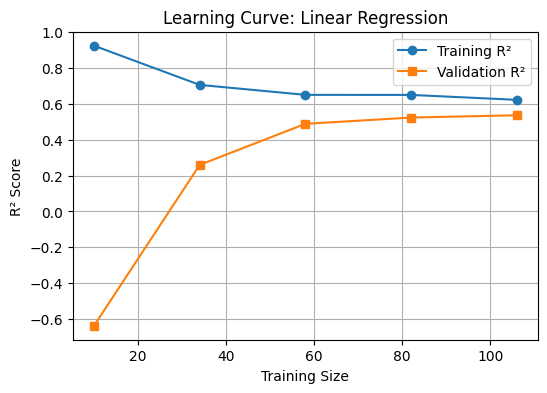

Polynomial Regression (deg=3):
  R² (Train): 0.895
  R² (Test):  -0.769
  RMSE:       0.189
----------------------------------------


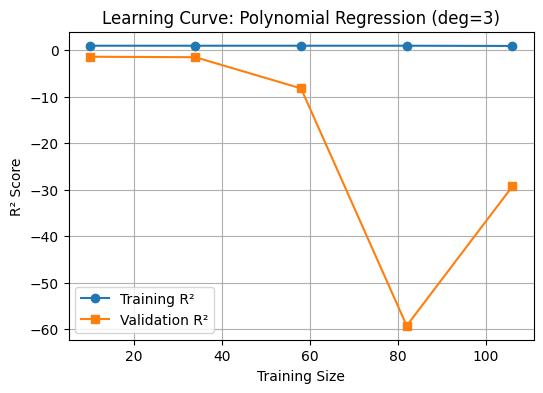


Model Comparison:
                            Model  R2_Train   R2_Test      RMSE
0              Linear Regression  0.614087  0.495227  0.100989
1  Polynomial Regression (deg=3)  0.895294 -0.768966  0.189054

Best Performing Model:
Model       Linear Regression
R2_Train             0.614087
R2_Test              0.495227
RMSE                 0.100989
Name: 0, dtype: object

Overfitting/Underfitting Check:
Linear Regression → Likely Overfitting (ΔR² = 0.12)
Polynomial Regression (deg=3) → Likely Overfitting (ΔR² = 1.66)


In [42]:

# Helper Functions
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    print(f"{name}:")
    print(f"  R² (Train): {train_r2:.3f}")
    print(f"  R² (Test):  {test_r2:.3f}")
    print(f"  RMSE:       {rmse:.3f}")
    print("-" * 40)
    
    return {
        "Model": name,
        "R2_Train": train_r2,
        "R2_Test": test_r2,
        "RMSE": rmse
    }

def plot_learning_curve(model, X, y, title):
    """Plot learning curve for given model."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5)
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, label='Training R²', marker='o')
    plt.plot(train_sizes, val_mean, label='Validation R²', marker='s')
    plt.xlabel('Training Size')
    plt.ylabel('R² Score')
    plt.title(f'Learning Curve: {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Train and Compare Models
results = []

models = [
    ("Linear Regression", LinearRegression(), X_train_ohe_scaled, X_test_ohe_scaled),
    ("Polynomial Regression (deg=3)",
     LinearRegression(),
     PolynomialFeatures(degree=3).fit_transform(X_train_ohe_scaled),
     PolynomialFeatures(degree=3).fit_transform(X_test_ohe_scaled)),
]

for name, model, Xtr, Xte in models:
    res = evaluate_model(model, Xtr, y_train_ohe, Xte, y_test_ohe, name)
    results.append(res)
    # Plot learning curve for each model
    plot_learning_curve(model, Xtr, y_train_ohe, name)


# Compare Results
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df)

# Identify Best Model
best_model = results_df.loc[results_df['R2_Test'].idxmax()]
print("\nBest Performing Model:")
print(best_model)

# Detect Overfitting / Underfitting
print("\nOverfitting/Underfitting Check:")
for row in results:
    diff = row["R2_Train"] - row["R2_Test"]
    if diff > 0.1:
        print(f"{row['Model']} → Likely Overfitting (ΔR² = {diff:.2f})")
    elif diff < -0.05:
        print(f"{row['Model']} → Likely Underfitting (ΔR² = {diff:.2f})")
    else:
        print(f"{row['Model']} → Well Balanced (ΔR² = {diff:.2f})")


Linear regression is generalizing considerably well though, slight overfitting

## 8. Classification models ##

**what we do here**
- create a new train data.
- create new test data to predict whether there will be fracture or not.
- use both train and test with a logistic regression model to predict fracture.
- use SVM model on new train and test data
- evaluate performance of both models



In [25]:
data_ohe_classification = pd.get_dummies(data, columns=['medication', 'sex'])
variables = data_ohe_classification.drop('fracture', axis=1)
target = data_ohe_classification['fracture']

x_fracture_train, x_fracture_test, y_fracture_train, y_fracture_test = train_test_split(variables, target, test_size=0.2, random_state=RANDOM_STATE)
print(f"\nX_fracture_train shape: {x_fracture_train.shape}")
print(f"\nX_fracture_test shape: {x_fracture_test.shape}")


X_fracture_train shape: (135, 10)

X_fracture_test shape: (34, 10)


**8.1 Logistic Model**

In [46]:
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],  
    'class_weight': [None, 'balanced']
}

log_model = LogisticRegression(max_iter=5000)

grid_search = GridSearchCV(log_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_fracture_train, y_fracture_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Predict with best estimator
best_log_model = grid_search.best_estimator_
y_pred_log = best_log_model.predict(x_fracture_test)
print("Logistic Training Successful")

Best Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV Score: 0.8903021442495127
Logistic Training Successful



Logistic Regression Model Evaluation:
Accuracy: 0.8529411764705882
Precision: 0.8888888888888888
Recall: 0.9230769230769231
F1 Score: 0.9056603773584906

Confusion Matrix:
 [[ 5  3]
 [ 2 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.89      0.92      0.91        26

    accuracy                           0.85        34
   macro avg       0.80      0.77      0.79        34
weighted avg       0.85      0.85      0.85        34

AUC: 0.8846153846153847


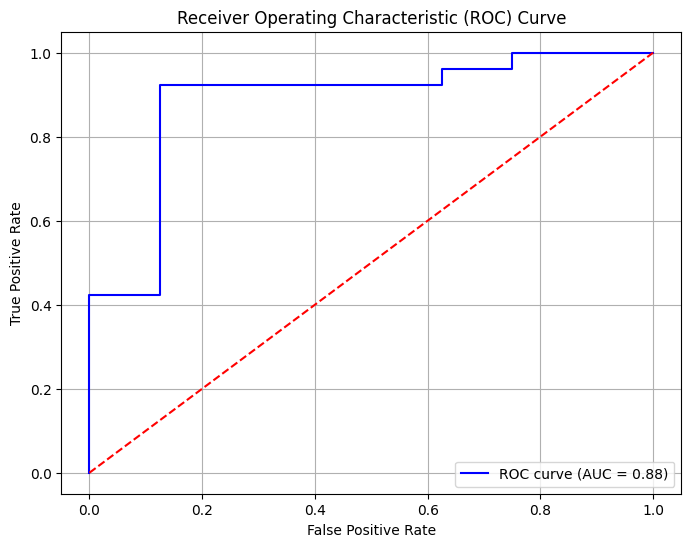

In [51]:
print("\nLogistic Regression Model Evaluation:")

print("Accuracy:", accuracy_score(y_fracture_test, y_pred_log))
print("Precision:", precision_score(y_fracture_test, y_pred_log))
print("Recall:", recall_score(y_fracture_test, y_pred_log))
print("F1 Score:", f1_score(y_fracture_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_fracture_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_log))

y_pred_prob = best_log_model.predict_proba(x_fracture_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_fracture_test, y_pred_prob)
auc_score = roc_auc_score(y_fracture_test, y_pred_prob)
print("AUC:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**8.2 SVM model**


=== Testing SVM with C=0.1 ===
Accuracy: 0.5294, Precision: 0.7273, Recall: 0.6154, F1 Score: 0.6667, ROC-AUC: 0.3750

=== Testing SVM with C=1 ===
Accuracy: 0.5882, Precision: 0.7500, Recall: 0.6923, F1 Score: 0.7200, ROC-AUC: 0.3654

=== Testing SVM with C=10 ===
Accuracy: 0.5294, Precision: 0.7273, Recall: 0.6154, F1 Score: 0.6667, ROC-AUC: 0.2933

=== Testing SVM with C=100 ===
Accuracy: 0.5294, Precision: 0.7273, Recall: 0.6154, F1 Score: 0.6667, ROC-AUC: 0.4038

===== SVM Performance Across C Values =====

       C  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0    0.1  0.529412   0.727273  0.615385  0.666667  0.375000
1    1.0  0.588235   0.750000  0.692308  0.720000  0.365385
2   10.0  0.529412   0.727273  0.615385  0.666667  0.293269
3  100.0  0.529412   0.727273  0.615385  0.666667  0.403846


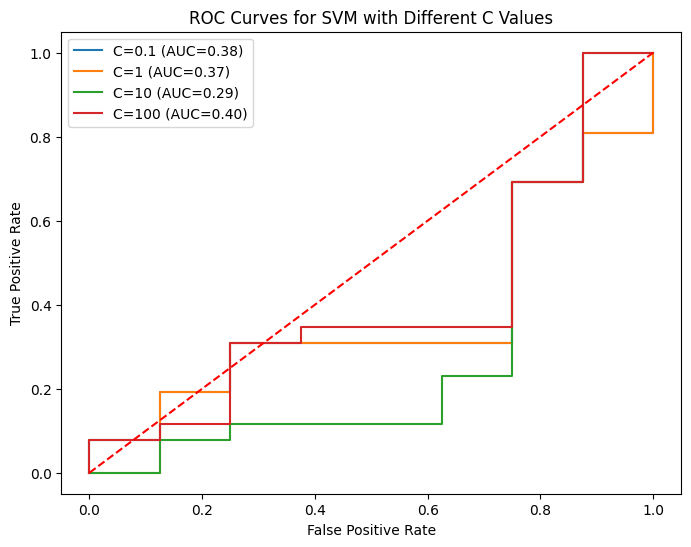

In [66]:
C_values = [0.1, 1, 10, 100]

results = []

for C in C_values:
    print(f"\n=== Testing SVM with C={C} ===")

    svm_model = SVC(C=C, kernel='rbf', class_weight='balanced', probability=True,  gamma='scale' )
    svm_model.fit(x_fracture_train, y_fracture_train)
    
    y_pred_hard = svm_model.predict(x_fracture_test)
    y_proba_soft = svm_model.predict_proba(x_fracture_test)[:, 1]
    
    # Metrics for hard predictions
    acc = accuracy_score(y_fracture_test, y_pred_hard)
    prec = precision_score(y_fracture_test, y_pred_hard)
    rec = recall_score(y_fracture_test, y_pred_hard)
    f1 = f1_score(y_fracture_test, y_pred_hard)
    
    # Metric for soft predictions
    roc_auc = roc_auc_score(y_fracture_test, y_proba_soft)

    results.append({
        "C": C,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    })

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

results_df = pd.DataFrame(results)
print("\n===== SVM Performance Across C Values =====\n")
print(results_df)


plt.figure(figsize=(8,6))
for r in results:
    C = r['C']
    svm_model = SVC(C=C, kernel='rbf', class_weight='balanced', probability=True)
    svm_model.fit(x_fracture_train, y_fracture_train)
    y_proba_soft = svm_model.predict_proba(x_fracture_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_fracture_test, y_proba_soft)
    auc_score = roc_auc_score(y_fracture_test, y_proba_soft)
    plt.plot(fpr, tpr, label=f"C={C} (AUC={auc_score:.2f})")

plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM with Different C Values")
plt.legend()
plt.show()

very low auc due to imbalanced dataset, smote might introduce noise though

**8.3 Comparison between Logistic and SVM**

In [62]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Store metrics
metrics = {
    "Accuracy": [
        accuracy_score(y_fracture_test, y_pred_log),
        accuracy_score(y_fracture_test, y_pred_hard)
    ],
    "Precision": [
        precision_score(y_fracture_test, y_pred_log),
        precision_score(y_fracture_test, y_pred_hard)
    ],
    "Recall": [
        recall_score(y_fracture_test, y_pred_log),
        recall_score(y_fracture_test, y_pred_hard)
    ],
    "F1 Score": [
        f1_score(y_fracture_test, y_pred_log),
        f1_score(y_fracture_test, y_pred_hard)
    ],
    "ROC-AUC": [
        roc_auc_score(y_fracture_test, y_pred_log),
        roc_auc_score(y_fracture_test, y_pred_hard)
    ]
}

models = ["Logistic Regression", "SVM (RBF Kernel)"]

comparison_df = pd.DataFrame(metrics, index=models)
print("\n===== MODEL PERFORMANCE COMPARISON =====\n")
print(comparison_df)

# Decide which model is better
# Priority: F1 Score (balanced), then Recall (clinical), then Accuracy, then ROC-AUC
log_score = (comparison_df.loc["Logistic Regression", "F1 Score"] * 0.4 +
             comparison_df.loc["Logistic Regression", "Recall"] * 0.25 +
             comparison_df.loc["Logistic Regression", "Accuracy"] * 0.2 +
             comparison_df.loc["Logistic Regression", "ROC-AUC"] * 0.15)

svm_score = (comparison_df.loc["SVM (RBF Kernel)", "F1 Score"] * 0.4 +
             comparison_df.loc["SVM (RBF Kernel)", "Recall"] * 0.25 +
             comparison_df.loc["SVM (RBF Kernel)", "Accuracy"] * 0.2 +
             comparison_df.loc["SVM (RBF Kernel)", "ROC-AUC"] * 0.15)

print("\n===== MODEL SELECTION RESULT =====\n")

if log_score > svm_score:
    best_model = "Logistic Regression"
else:
    best_model = "SVM"

print(f"Best Model: {best_model}\n")

# Explanation generator
def explain_results(best_model, comparison_df):
    log = comparison_df.loc["Logistic Regression"]
    svm = comparison_df.loc["SVM (RBF Kernel)"]

    print("===== CONCLUSION =====")

    if best_model == "Logistic Regression":
        print(
            f"""
Logistic Regression outperformed the SVM model.

Reasons:
- Higher Accuracy ({log['Accuracy']:.2f} vs {svm['Accuracy']:.2f})
- Higher Recall ({log['Recall']:.2f} vs {svm['Recall']:.2f})
- Higher F1 Score ({log['F1 Score']:.2f} vs {svm['F1 Score']:.2f})
- Higher ROC-AUC ({log['ROC-AUC']:.2f} vs {svm['ROC-AUC']:.2f})
            """
        )
    else:
        print(
            f"""
The SVM model outperformed Logistic Regression.

Reasons:
- Higher Accuracy ({svm['Accuracy']:.2f} vs {log['Accuracy']:.2f})
- Higher Recall ({svm['Recall']:.2f} vs {log['Recall']:.2f})
- Higher F1 Score ({svm['F1 Score']:.2f} vs {log['F1 Score']:.2f})
- Higher ROC-AUC ({svm['ROC-AUC']:.2f} vs {log['ROC-AUC']:.2f})
            """
        )

explain_results(best_model, comparison_df)



===== MODEL PERFORMANCE COMPARISON =====

                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression  0.852941   0.888889  0.923077  0.905660  0.774038
SVM (RBF Kernel)     0.529412   0.727273  0.615385  0.666667  0.432692

===== MODEL SELECTION RESULT =====

Best Model: Logistic Regression

===== CONCLUSION =====

Logistic Regression outperformed the SVM model.

Reasons:
- Higher Accuracy (0.85 vs 0.53)
- Higher Recall (0.92 vs 0.62)
- Higher F1 Score (0.91 vs 0.67)
- Higher ROC-AUC (0.77 vs 0.43)
            


**8.4 Naive Bayes**
**what we do here**
- use data prepared for fracture classification 
- apply Naive Bayes model

In [29]:
scaler = StandardScaler()
X_train_c_scaled = scaler.fit_transform(x_fracture_train)
X_test_c_scaled = scaler.transform(x_fracture_test)
nb_model = GaussianNB()
nb_model.fit(X_train_c_scaled, y_fracture_train)
y_pred_nb = nb_model.predict(X_test_c_scaled)

print("=== Naive Bayes Performance ===")
print("Accuracy:", accuracy_score(y_fracture_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_nb))

=== Naive Bayes Performance ===
Accuracy: 0.8235294117647058

Classification Report:
               precision    recall  f1-score   support

    fracture       0.67      0.50      0.57         8
 no fracture       0.86      0.92      0.89        26

    accuracy                           0.82        34
   macro avg       0.76      0.71      0.73        34
weighted avg       0.81      0.82      0.81        34



**8.5 Decision Tree**

In [27]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_fracture_train, y_fracture_train) 
y_pred_dt = dt_model.predict(x_fracture_test)

print("\n=== Decision Tree (Default) Performance ===")
print("Accuracy:", accuracy_score(y_fracture_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_fracture_test, y_pred_dt))


=== Decision Tree (Default) Performance ===
Accuracy: 0.8235294117647058

Classification Report:
               precision    recall  f1-score   support

    fracture       0.62      0.62      0.62         8
 no fracture       0.88      0.88      0.88        26

    accuracy                           0.82        34
   macro avg       0.75      0.75      0.75        34
weighted avg       0.82      0.82      0.82        34



**8.6 How depth of DT affects accuracy**

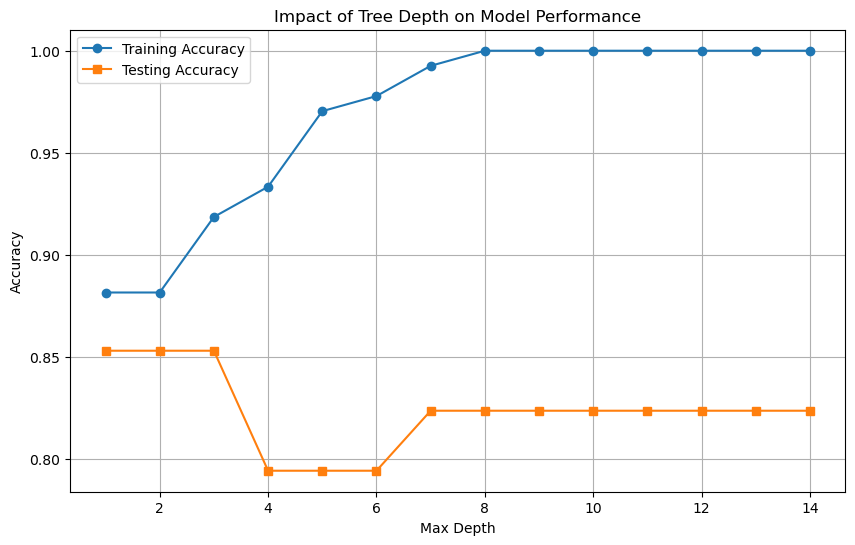

In [28]:
# Experimenting with Tree Depth
train_accuracies = []
test_accuracies = []
depths = range(1, 15)

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(x_fracture_train, y_fracture_train)
    
    train_accuracies.append(accuracy_score(y_fracture_train, dt.predict(x_fracture_train)))
    test_accuracies.append(accuracy_score(y_fracture_test, dt.predict(x_fracture_test)))

# Plotting the impact
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Testing Accuracy', marker='s')
plt.title('Impact of Tree Depth on Model Performance')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()